In [34]:
import shutil
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import copy

In [26]:
mesh_mask       = '/home/users/jmecking001/DATASETS/ORAS5/mesh_mask.nc'
mesh_mask_jenny = '/home/users/jmecking001/DATASETS/ORAS5/e3_jenny.nc'
basins          = '/home/users/jmecking001/DATASETS/ORAS5/basins.nc'

In [4]:
ncid = Dataset(mesh_mask,'r')
tmask  = np.squeeze(ncid.variables['tmask'][:,:,:,:])
e3t_ps = np.squeeze(ncid.variables['e3t_ps'][:,:,:])
e3t_0  = ncid.variables['e3t_0'][:]
ncid.close()

In [5]:
nx = np.size(tmask,axis=2)
ny = np.size(tmask,axis=1)
nz = np.size(tmask,axis=0)

e3t = np.swapaxes(np.tile(e3t_0,(nx,ny,1)),0,2)*tmask
# Add in partial cells:
for yy in range(0,ny):
    #print(yy/ny)
    for xx in range(0,nx):
        if (np.sum(tmask[:,yy,xx]) != 0):
            ind = np.squeeze(np.where(tmask[:,yy,xx] == 0))
            if np.size(ind) == 0:
                indz = 74
            elif np.size(ind) == 1:
                indz = 73
            else:
                indz = ind[0]-1
                
            #print(indz)
            e3t[indz,yy,xx] = e3t_ps[yy,xx]

In [6]:
ncid = Dataset(mesh_mask_jenny,'w')
# coordinates:
ncid.createDimension('x',nx)
ncid.createDimension('y',ny)
ncid.createDimension('z',nz)
ncid.createDimension('t',None)
ncid.createVariable('e3t','f8',('t','z','y','x'))
ncid.variables['e3t'][0,:,:,:] = e3t
ncid.close()

In [9]:
ncid = Dataset(mesh_mask,'r')
tlat  = np.squeeze(ncid.variables['gphit'][:,:])
tlon  = np.squeeze(ncid.variables['glamt'][:,:])
ulat  = np.squeeze(ncid.variables['gphiu'][:,:])
ulon  = np.squeeze(ncid.variables['glamu'][:,:])
vlat  = np.squeeze(ncid.variables['gphiv'][:,:])
vlon  = np.squeeze(ncid.variables['glamv'][:,:])
ncid.close()

# Grid = Ctr
# extra E/W = [1,1]

In [32]:
# Check if variable exists in netCDF file:
def check_var(infile,var):
    ncid = Dataset(infile,'r')
    vars = ncid.variables.keys()
    ncid.close()
    
    if var in vars:
        return True
    else:
        return False

# Finds all points in a closed region (non-recursive):
def find_points(A,sty,stx):
    ni = np.size(A,axis=1)
    nj = np.size(A,axis=0)
    #print(ni*nj)
    
    if A[sty,stx] == 0:
        print('invalid starting point')
    else:
        plist = np.asarray([[sty,stx],])
        
        cc = 0
        
        while ((np.size(plist) !=0)):
            cc = cc + 1
            #print(np.shape(plist))

            sty = plist[0,0]
            stx = plist[0,1]
            
            if A[sty,stx] == 1:
                # Find all the connected points:
                
                # left
                ptx = stx - 1
                pty = sty
                if ptx == -1:
                    ptx = ni-1
                if A[pty,ptx] == 1:
                    plist = np.concatenate((plist,[[pty,ptx],]),0)
                
                # up
                ptx = stx
                pty = sty + 1
                if pty < nj:   
                    if A[pty,ptx] == 1:
                        plist = np.concatenate((plist,[[pty,ptx],]),0)

                # right 
                ptx = stx + 1
                pty = sty
                if ptx == ni:
                    ptx = 0
                if A[pty,ptx] == 1:  
                    plist = np.concatenate((plist,[[pty,ptx],]),0)

                # down
                ptx = stx
                pty = sty - 1
                if pty >= 0:
                    if A[pty,ptx] == 1:
                        plist = np.concatenate((plist,[[pty,ptx],]),0)
                
            A[sty,stx] = 2
            plist = np.delete(plist,0,0)
            
    A[np.where(A != 2)] = 0
    A[np.where(A == 2)] = 1
    print(cc)
    
    
def find_points2(A,sty,stx):
    ni = np.size(A,axis=1)
    nj = np.size(A,axis=0)
    #print(ni*nj)
    
    if A[sty,stx] == 0:
        print('invalid starting point')
    else:
        plist = np.asarray([[sty,stx],])
        
        cc = 0
        
        while ((np.size(plist) !=0) & (cc < 52000)):
            cc = cc + 1
            #print(np.shape(plist))

            sty = plist[0,0]
            stx = plist[0,1]
            
            if A[sty,stx] == 1:
                # Find all the connected points:
                
                # left
                ptx = stx - 1
                pty = sty
                if ptx == -1:
                    ptx = ni-1
                if A[pty,ptx] == 1:
                    plist = np.concatenate((plist,[[pty,ptx],]),0)
                
                # up
                ptx = stx
                pty = sty + 1
                if pty < nj:   
                    if A[pty,ptx] == 1:
                        plist = np.concatenate((plist,[[pty,ptx],]),0)

                # right 
                ptx = stx + 1
                pty = sty
                if ptx == ni:
                    ptx = 0
                if A[pty,ptx] == 1:  
                    plist = np.concatenate((plist,[[pty,ptx],]),0)

                # down
                ptx = stx
                pty = sty - 1
                if pty >= 0:
                    if A[pty,ptx] == 1:
                        plist = np.concatenate((plist,[[pty,ptx],]),0)
                
            A[sty,stx] = 2
            plist = np.delete(plist,0,0)
            
    A[np.where(A != 2)] = 0
    A[np.where(A == 2)] = 1
    print(cc)

/home/users/jmecking001/DATASETS/ORAS5/basins.nc already exists


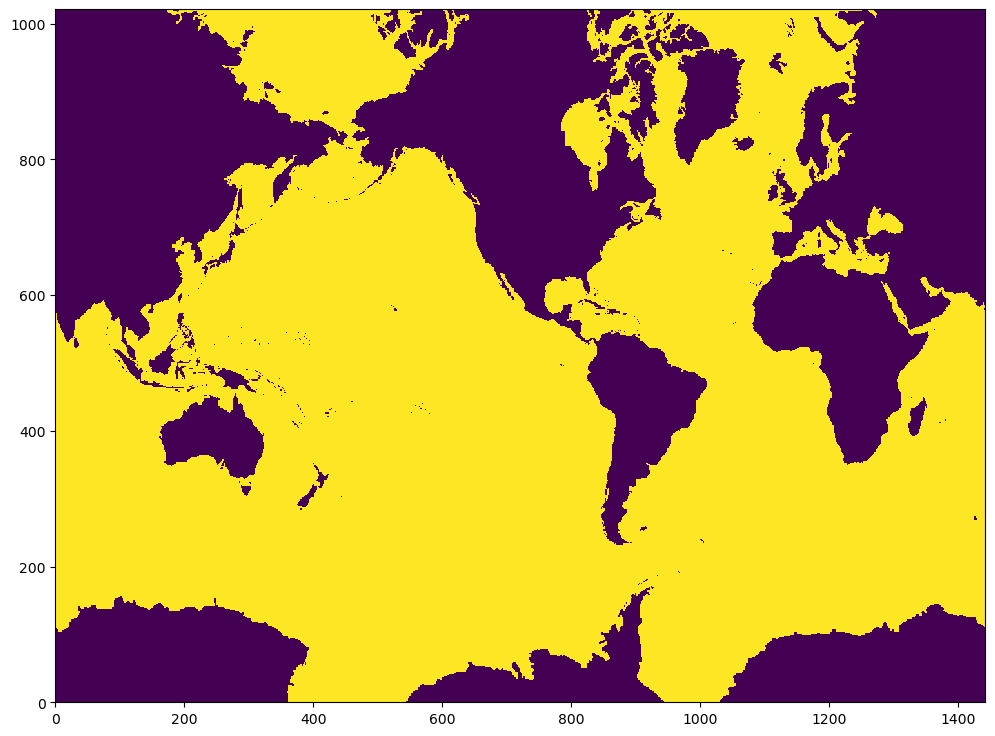

In [30]:
if os.path.isfile(basins):
    print(basins + ' already exists')

    # Read in variables:
    ncid = Dataset(basins,'r')
    tmask = np.squeeze(ncid.variables['Tmask'][:,:])
    lon  = np.squeeze(ncid.variables['lon'][:,:])
    lat  = np.squeeze(ncid.variables['lat'][:,:])
    ncid.close()
else:
    ncid  = Dataset(mesh_mask)
    dims  = ncid.variables['tmask'].get_dims()
    tmask = np.squeeze(ncid.variables['tmask'][0,0,:,:])
    lon  = np.squeeze(ncid.variables['glamt'][:,:])
    lat  = np.squeeze(ncid.variables['gphit'][:,:])
    ncid.close

    # Make consistant longitude range:
    lon[np.where(lon > 180)]  = lon[np.where(lon > 180)]  - 360
    lon[np.where(lon < -180)] = lon[np.where(lon < -180)] + 360

    print('creating ' + basins)

    ncid = Dataset(basins, 'w', format='NETCDF4')
    # dimensions:
    ncid.createDimension(dims[3].name,dims[3].size)
    ncid.createDimension(dims[2].name,dims[2].size)
    # variables:
    ncid.createVariable('lon'  ,'f8',(dims[2].name,dims[3].name,))
    ncid.createVariable('lat'  ,'f8',(dims[2].name,dims[3].name,))
    ncid.createVariable('Tmask','f8',(dims[2].name,dims[3].name,))
    # fill variables:
    ncid.variables['lon'][:,:]   = lon
    ncid.variables['lat'][:,:]   = lat
    ncid.variables['Tmask'][:,:] = tmask
    # close:
    ncid.close()

plt.figure(figsize=(12,9))
plt.pcolormesh(tmask)

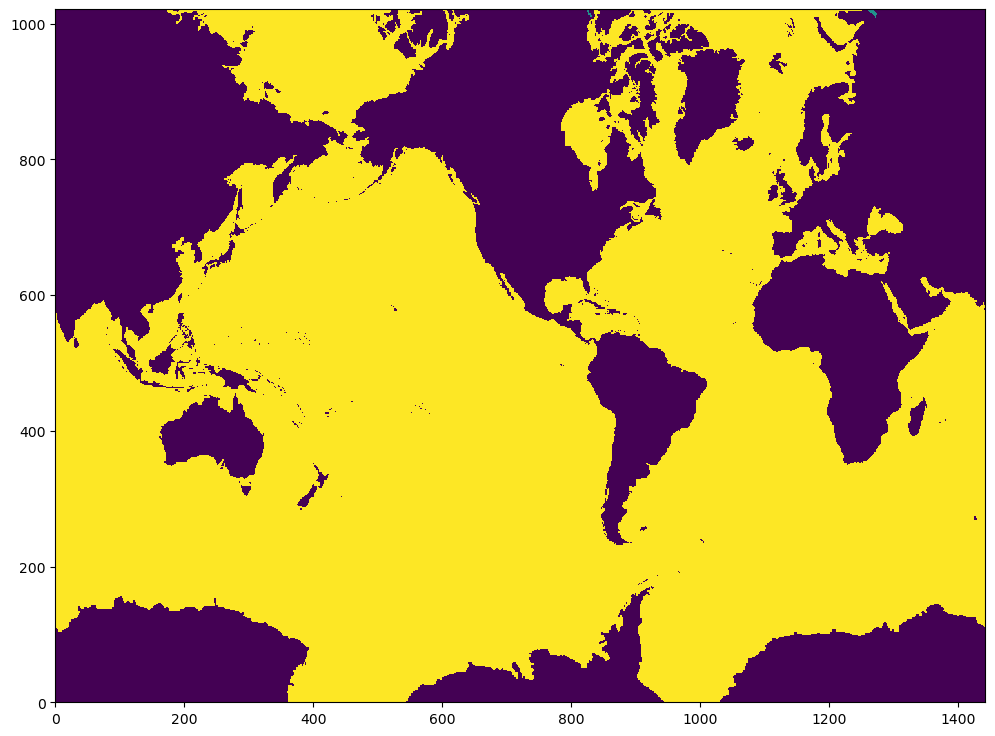

In [36]:
# Compute connected basins if not included:   
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'Connected'):
        ncid  = Dataset(basins,'r')
        dims  = ncid.variables['Tmask'].get_dims()
        lon   = ncid.variables['lon'][:,:]
        lat   = ncid.variables['lat'][:,:]
        tmask = ncid.variables['Tmask'][:,:]
        ncid.close()

        # Starting point in Atlantic:
        inds = np.unravel_index(np.argmin(np.abs(lat-50)+np.abs(lon+40)),np.shape(lon))
        sty = inds[0]
        stx = inds[1]

        connected = copy.deepcopy(tmask)
        find_points(connected,sty,stx)

        ncid = Dataset(basins,'a')
        ncid.createVariable('Connected','f8',(dims[0].name,dims[1].name,))
        ncid.variables['Connected'][:,:] = connected
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+connected)
        plt.plot(stx,sty,marker='o')
    else:
        ncid = Dataset(basins,'r')
        tmask     = ncid.variables['Tmask'][:,:]
        connected = ncid.variables['Connected'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+connected)

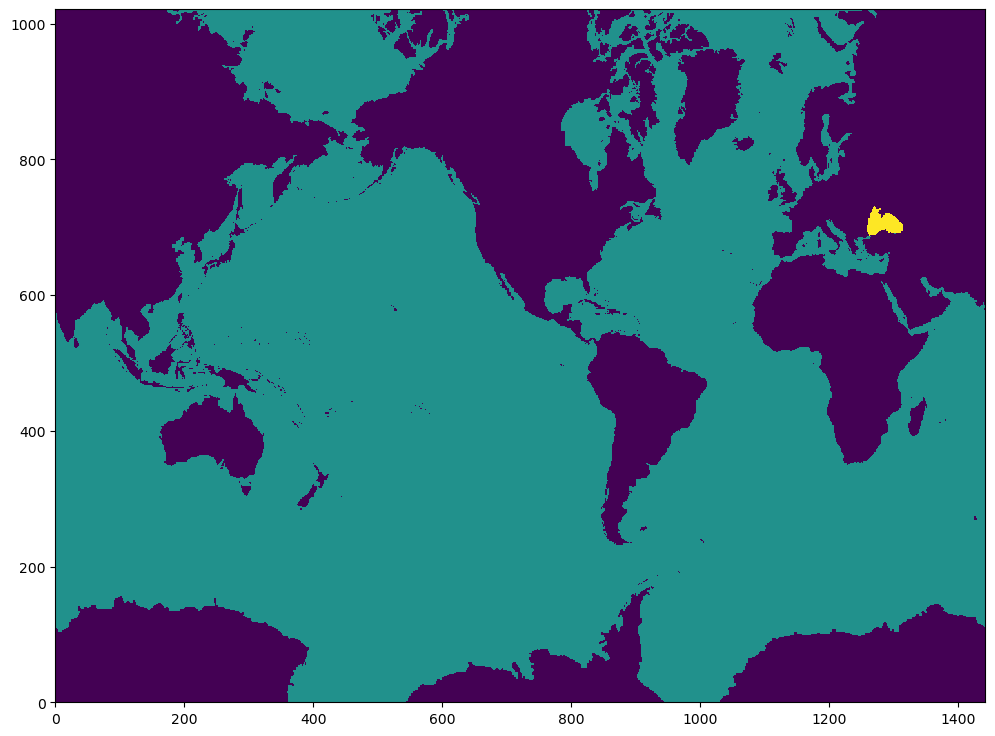

In [39]:
# Compute Black Sea if not Computed:

# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'BlackSea'):

        ncid  = Dataset(basins,'r')
        dims  = ncid.variables['Tmask'].get_dims()
        lon   = ncid.variables['lon'][:,:]
        lat   = ncid.variables['lat'][:,:]
        tmask = ncid.variables['Tmask'][:,:]
        ncid.close()

        blackSea = copy.deepcopy(tmask)

        # Define Black Sea Region:
        blackSea[np.where(((lat < 41) | (lat > 48)) | ((lon < 22) | (lon > 45)))] = 0

        ncid = Dataset(basins,'a')
        ncid.createVariable('BlackSea','f8',(dims[0].name,dims[1].name,))
        ncid.variables['BlackSea'][:,:] = blackSea
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+blackSea,vmin=0,vmax=2)
    else:
        ncid = Dataset(basins,'r')
        tmask     = ncid.variables['Tmask'][:,:]
        blackSea = ncid.variables['BlackSea'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+blackSea,vmin=0,vmax=2)

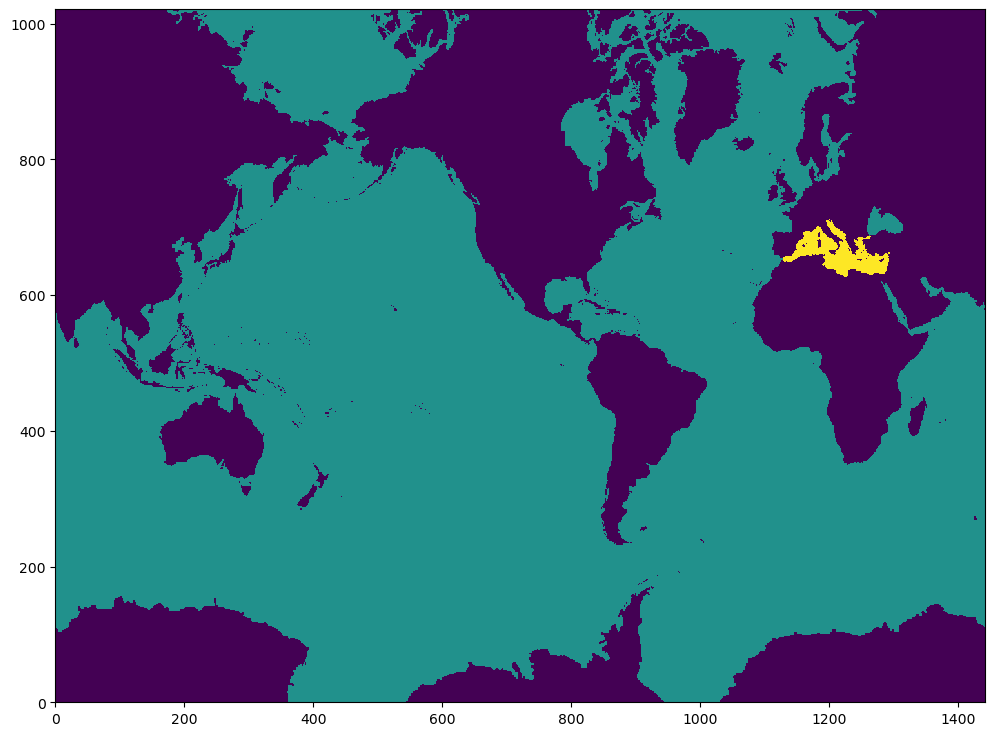

In [43]:
# Compute Mediterranean Sea if not Computed:

# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'MediterraneanSea'):

        ncid     = Dataset(basins,'r')
        dims     = ncid.variables['Tmask'].get_dims()
        lon      = ncid.variables['lon'][:,:]
        lat      = ncid.variables['lat'][:,:]
        tmask    = ncid.variables['Tmask'][:,:]
        BlackSea = ncid.variables['BlackSea'][:,:]
        ncid.close()

        MediterraneanSea = copy.deepcopy(tmask)
        # Remove Black Sea:
        MediterraneanSea = MediterraneanSea - BlackSea

        # Strait of Gilbraltar Boundary:
        ilon = np.argmin(np.abs(lon+5.3),axis=1)
        for kk in range(0,len(ilon)):
            MediterraneanSea[kk,ilon[kk]-1] = 0

        # Starting point in Mediterranean Sea:
        inds = np.unravel_index(np.argmin(np.abs(lat-40)+np.abs(lon-5)),np.shape(lon))
        sty = inds[0]
        stx = inds[1]

        find_points(MediterraneanSea,sty,stx)

        ncid = Dataset(basins,'a')
        ncid.createVariable('MediterraneanSea','f8',(dims[0].name,dims[1].name,))
        ncid.variables['MediterraneanSea'][:,:] = MediterraneanSea
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+MediterraneanSea,vmin=0,vmax=2)
        plt.plot(stx,sty,marker='o')
    else:

        ncid = Dataset(basins,'r')
        tmask            = ncid.variables['Tmask'][:,:]
        MediterraneanSea = ncid.variables['MediterraneanSea'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+MediterraneanSea,vmin=0,vmax=2)

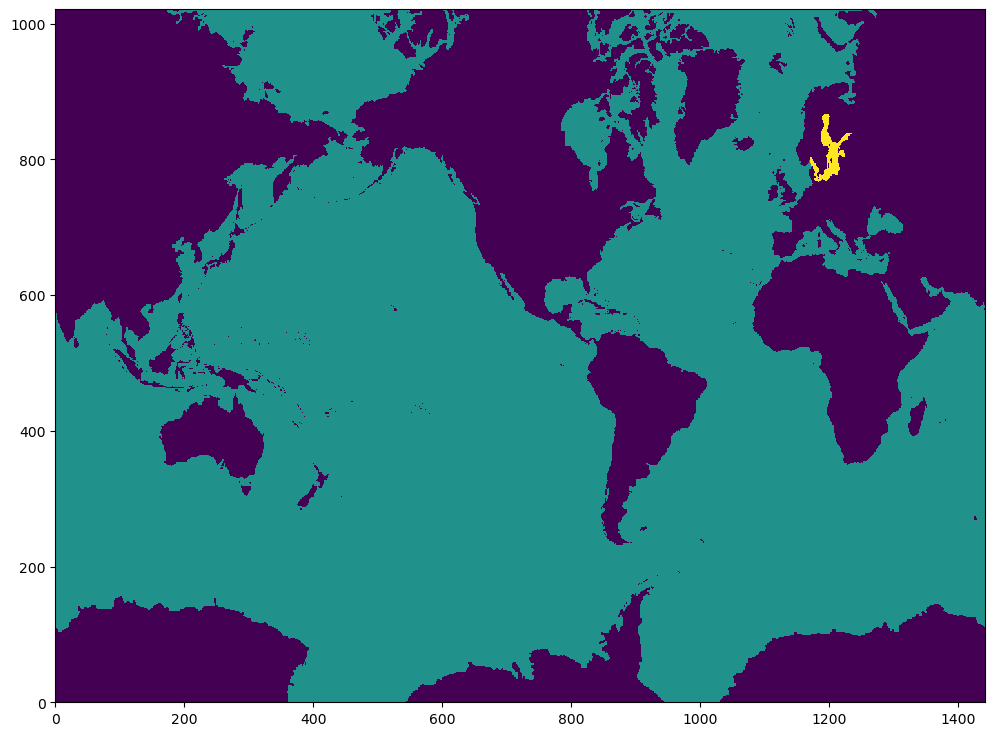

In [49]:
# Compute Baltic Sea if not Computed:
    
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'BalticSea'):

        ncid     = Dataset(basins,'r')
        dims     = ncid.variables['Tmask'].get_dims()
        lon      = ncid.variables['lon'][:,:]
        lat      = ncid.variables['lat'][:,:]
        tmask    = ncid.variables['Tmask'][:,:]
        ncid.close()

        BalticSea = copy.deepcopy(tmask)

        # Starting point in Baltic Sea:
        inds = np.unravel_index(np.argmin(np.abs(lat-58.6)+np.abs(lon-19.8)),np.shape(lon))
        sty = inds[0]
        stx = inds[1]

        # Skagerrak Boundary:
        ilon = np.argmin(np.abs(lon-10),axis=1)
        for kk in range(0,len(ilon)):
            BalticSea[kk,ilon[kk]-1] = 0

        find_points(BalticSea,sty,stx)

        ncid = Dataset(basins,'a')
        ncid.createVariable('BalticSea','f8',(dims[0].name,dims[1].name,))
        ncid.variables['BalticSea'][:,:] = BalticSea
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+BalticSea,vmin=0,vmax=2)
        plt.plot(stx,sty,marker='o')
    else:

        ncid = Dataset(basins,'r')
        tmask            = ncid.variables['Tmask'][:,:]
        BalticSea        = ncid.variables['BalticSea'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+BalticSea,vmin=0,vmax=2)

16111


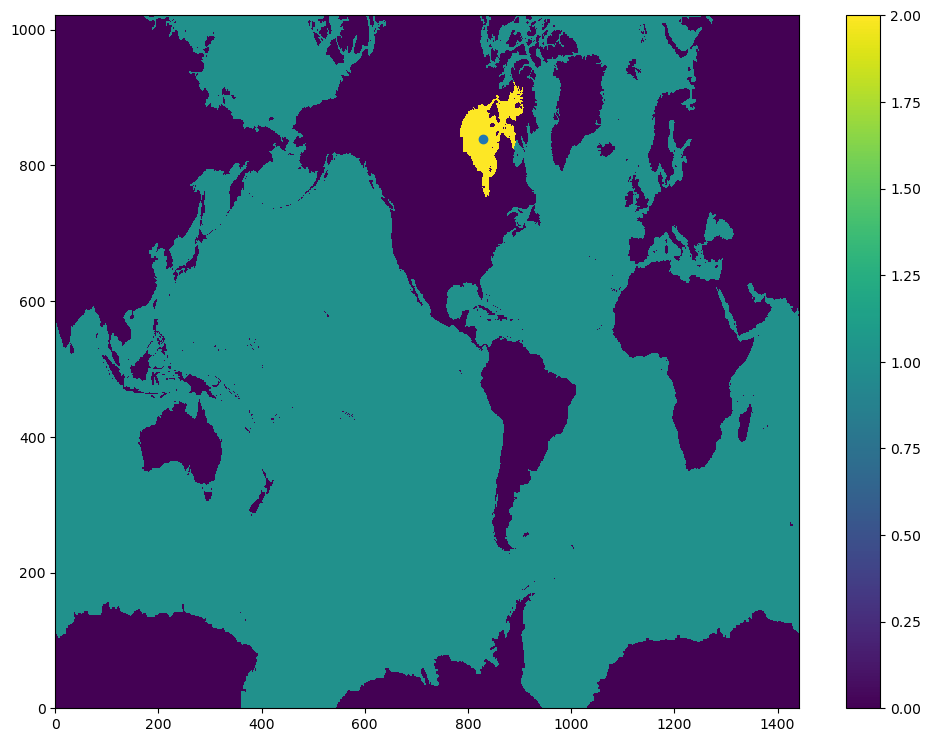

In [51]:
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'HudsonBay'):
        ncid     = Dataset(basins,'r')
        dims     = ncid.variables['Tmask'].get_dims()
        lon      = ncid.variables['lon'][:,:]
        lat      = ncid.variables['lat'][:,:]
        tmask    = ncid.variables['Tmask'][:,:]
        ncid.close()

        HudsonBay = copy.deepcopy(tmask)

        # Starting point in Hudson Bay:
        inds = np.unravel_index(np.argmin(np.abs(lat-60)+np.abs(lon+85)),np.shape(lon))
        sty = inds[0]
        stx = inds[1]

        # Hudson Strait Boundary:
        ilon = np.argmin(np.abs(lon+70),axis=1)
        for kk in range(0,len(ilon)):
            HudsonBay[kk,ilon[kk]-1] = 0


        # Close off Northwest Passage:
        ilon = np.argmin(np.abs(lon+84),axis=1)
        for kk in range(0,len(ilon)):
            if ((lat[kk,ilon[kk]] > 69) | (lat[kk,ilon[kk]] > 70.5)):
                HudsonBay[kk,ilon[kk]-1] = 0

        find_points(HudsonBay,sty,stx)

        ncid = Dataset(basins,'a')
        ncid.createVariable('HudsonBay','f8',(dims[0].name,dims[1].name,))
        ncid.variables['HudsonBay'][:,:] = HudsonBay
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+HudsonBay,vmin=0,vmax=2)
        plt.plot(stx,sty,marker='o')
        #plt.xlim([260,300])
        #plt.ylim([150,170])
        plt.colorbar()
    else:

        ncid = Dataset(basins,'r')
        tmask            = ncid.variables['Tmask'][:,:]
        HudsonBay        = ncid.variables['HudsonBay'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+HudsonBay,vmin=0,vmax=2)
        plt.title(Model.name,fontsize=18)

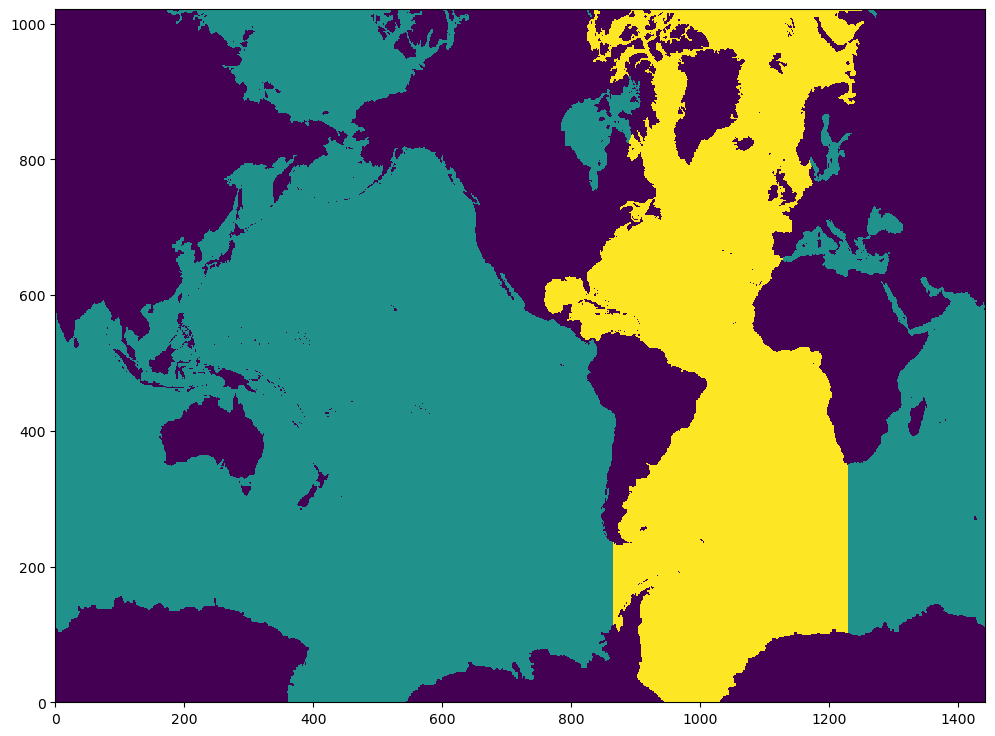

In [56]:
# Compute Atlantic if not Computed:
    
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'Atlantic'):

        ncid             = Dataset(basins,'r')
        dims             = ncid.variables['Tmask'].get_dims()
        lon              = ncid.variables['lon'][:,:]
        lat              = ncid.variables['lat'][:,:]
        tmask            = ncid.variables['Tmask'][:,:]
        MediterraneanSea = ncid.variables['MediterraneanSea'][:,:]
        BalticSea        = ncid.variables['BalticSea'][:,:]
        HudsonBay        = ncid.variables['HudsonBay'][:,:]
        ncid.close()

        Atlantic = copy.deepcopy(tmask)
        Atlantic = Atlantic - MediterraneanSea - BalticSea - HudsonBay

        # Starting point in Atlantic:
        inds = np.unravel_index(np.argmin(np.abs(lat-50)+np.abs(lon+40)),np.shape(lon))
        sty = inds[0]
        stx = inds[1] 

        # Drake Passage Boundary:
        ilon = np.argmin(np.abs(lon+71),axis=1)
        for kk in range(0,len(ilon)):
            if lat[kk,ilon[kk]] < -30:
                Atlantic[kk,ilon[kk]-1] = 0

        # South Africa Boundary:
        ilon = np.argmin(np.abs(lon-20.5),axis=1)
        for kk in range(0,len(ilon)):
            if lat[kk,ilon[kk]] < -30:
                Atlantic[kk,ilon[kk]-1] = 0

        find_points(Atlantic,sty,stx)

        if (np.sum(Atlantic) > 0.85*np.sum(tmask)):

            Atlantic = copy.deepcopy(tmask)
            Atlantic = Atlantic - MediterraneanSea - BalticSea - HudsonBay

            # Drake Passage Boundary:
            ilon = np.argmin(np.abs(lon+71),axis=1)
            for kk in range(0,len(ilon)):
                if lat[kk,ilon[kk]] < -30:
                    Atlantic[kk,ilon[kk]-1] = 0

            # South Africa Boundary:
            ilon = np.argmin(np.abs(lon-20.5),axis=1)
            for kk in range(0,len(ilon)):
                if lat[kk,ilon[kk]] < -30:
                    Atlantic[kk,ilon[kk]-1] = 0

            # Arctic:
            Atlantic[np.where((lat > 67) & ((lon > 105) | (lon < -90)))] = 0                
            find_points(Atlantic,sty,stx)

        ncid = Dataset(basins,'r+')
        ncid.createVariable('Atlantic','f8',(dims[0].name,dims[1].name,))
        ncid.variables['Atlantic'][:,:] = Atlantic
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+Atlantic,vmin=0,vmax=2)
        plt.plot(stx,sty,marker='o')
        #plt.xlim([250,350])
        #plt.ylim([80,120])
        plt.colorbar()

    else:

        ncid = Dataset(basins,'r')
        tmask            = ncid.variables['Tmask'][:,:]
        Atlantic         = ncid.variables['Atlantic'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+Atlantic,vmin=0,vmax=2)

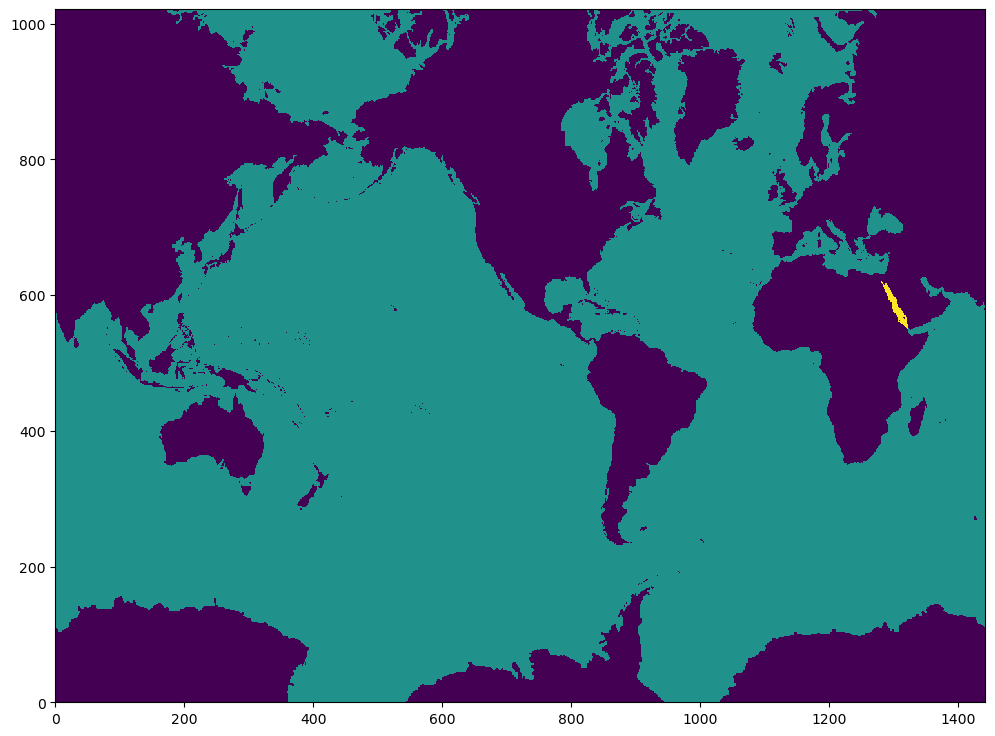

In [61]:
# Compute Red Sea if not Computed:
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'RedSea'):

        ncid  = Dataset(basins,'r')
        dims  = ncid.variables['Tmask'].get_dims()
        lon   = ncid.variables['lon'][:,:]
        lat   = ncid.variables['lat'][:,:]
        tmask = ncid.variables['Tmask'][:,:]
        ncid.close()

        RedSea = copy.deepcopy(tmask)

        # Define Red Sea Region:
        RedSea[np.where(((lat < 12.5) | (lat > 30)) | ((lon < 32) | (lon > 43.25)))] = 0

        ncid = Dataset(basins,'a')
        ncid.createVariable('RedSea','f8',(dims[0].name,dims[1].name,))
        ncid.variables['RedSea'][:,:] = RedSea
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+RedSea,vmin=0,vmax=2)
    else:

        ncid = Dataset(basins,'r')
        tmask     = ncid.variables['Tmask'][:,:]
        RedSea = ncid.variables['RedSea'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+RedSea,vmin=0,vmax=2)

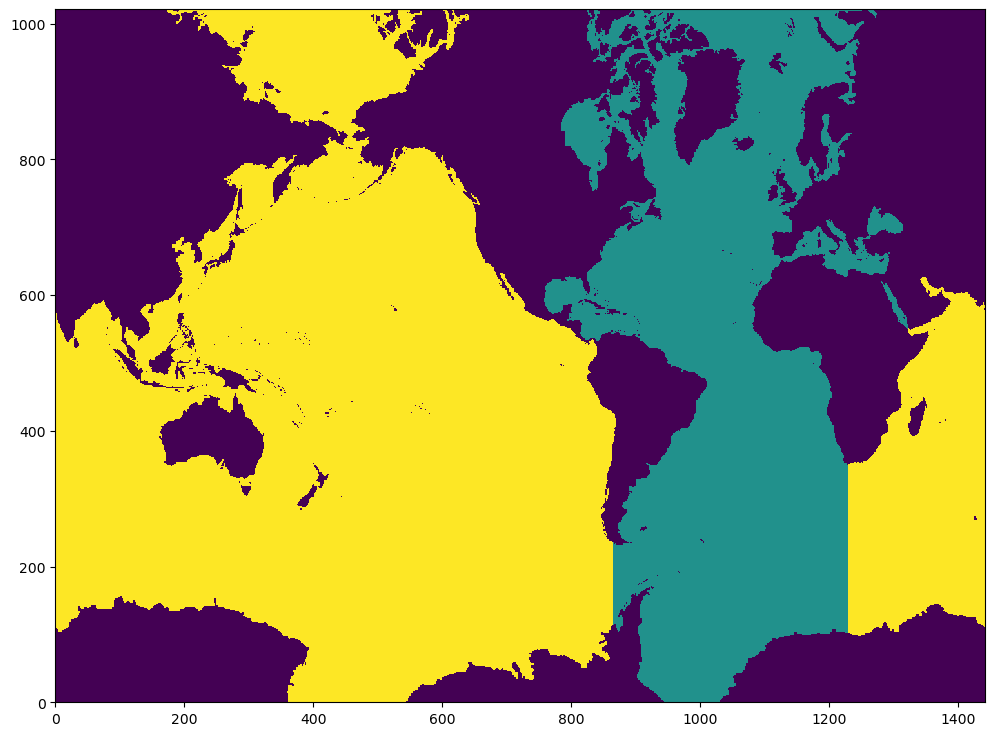

In [65]:
# Compute Indo-Pacific if not Computed:    
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'IndoPacific'):

        ncid             = Dataset(basins,'r')
        dims             = ncid.variables['Tmask'].get_dims()
        lon              = ncid.variables['lon'][:,:]
        lat              = ncid.variables['lat'][:,:]
        tmask            = ncid.variables['Tmask'][:,:]
        RedSea           = ncid.variables['RedSea'][:,:]
        Atlantic         = ncid.variables['Atlantic'][:,:]
        ncid.close()

        IndoPacific = copy.deepcopy(tmask)
        IndoPacific = IndoPacific - Atlantic - RedSea

        # Starting point in Pacific:
        inds = np.unravel_index(np.argmin(np.abs(lat-50)+np.abs(lon+140)),np.shape(lon))
        sty = inds[0]
        stx = inds[1] 

        find_points(IndoPacific,sty,stx)

        ncid = Dataset(basins,'a')
        ncid.createVariable('IndoPacific','f8',(dims[0].name,dims[1].name,))
        ncid.variables['IndoPacific'][:,:] = IndoPacific
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+IndoPacific,vmin=0,vmax=2)
        plt.plot(stx,sty,marker='o')
        plt.colorbar()
    else:

        ncid = Dataset(basins,'r')
        tmask            = ncid.variables['Tmask'][:,:]
        IndoPacific      = ncid.variables['IndoPacific'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+IndoPacific,vmin=0,vmax=2)

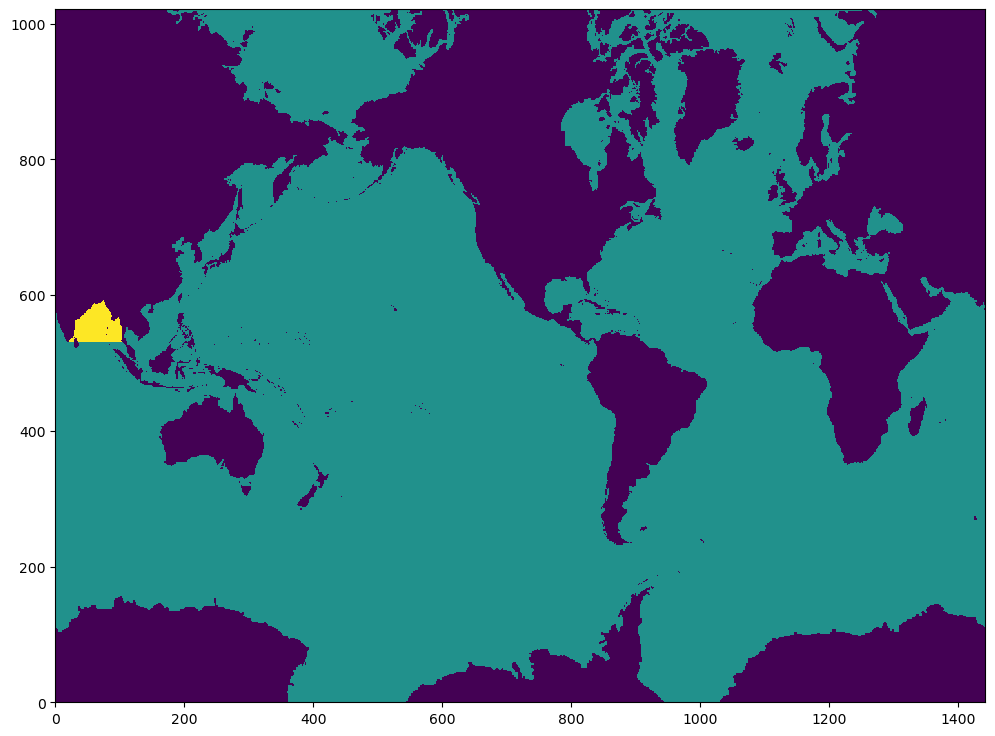

In [70]:
# Compute BayOfBengal if not Computed: 
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'BayOfBengal'):

        ncid  = Dataset(basins,'r')
        dims  = ncid.variables['Tmask'].get_dims()
        lon   = ncid.variables['lon'][:,:]
        lat   = ncid.variables['lat'][:,:]
        tmask            = ncid.variables['Tmask'][:,:]
        IndoPacific = ncid.variables['IndoPacific'][:,:]
        ncid.close()

        BayOfBengal = copy.deepcopy(IndoPacific)

        # Define Bay of Bengal Region:
        BayOfBengal[np.where(((lat < 8) | (lat > 25)) | ((lon < 77) | (lon > 99)))] = 0

        # Starting point in Bay of Bengal:
        inds = np.unravel_index(np.argmin(np.abs(lat-15)+np.abs(lon-90)),np.shape(lon))
        sty = inds[0]
        stx = inds[1]

        find_points(BayOfBengal,sty,stx)

        ncid = Dataset(basins,'a')
        ncid.createVariable('BayOfBengal','f8',(dims[0].name,dims[1].name,))
        ncid.variables['BayOfBengal'][:,:] = BayOfBengal
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+BayOfBengal,vmin=0,vmax=2)
        plt.plot(stx,sty,marker='o')
    else:
        ncid = Dataset(basins,'r')
        tmask     = ncid.variables['Tmask'][:,:]
        BayOfBengal = ncid.variables['BayOfBengal'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+BayOfBengal,vmin=0,vmax=2)

# Potential fixes:
# Reducing box size to cut off Indonesian through flow (~99E)
# Look at depths to define Indonesian through flow (define eastern cut off longitude)

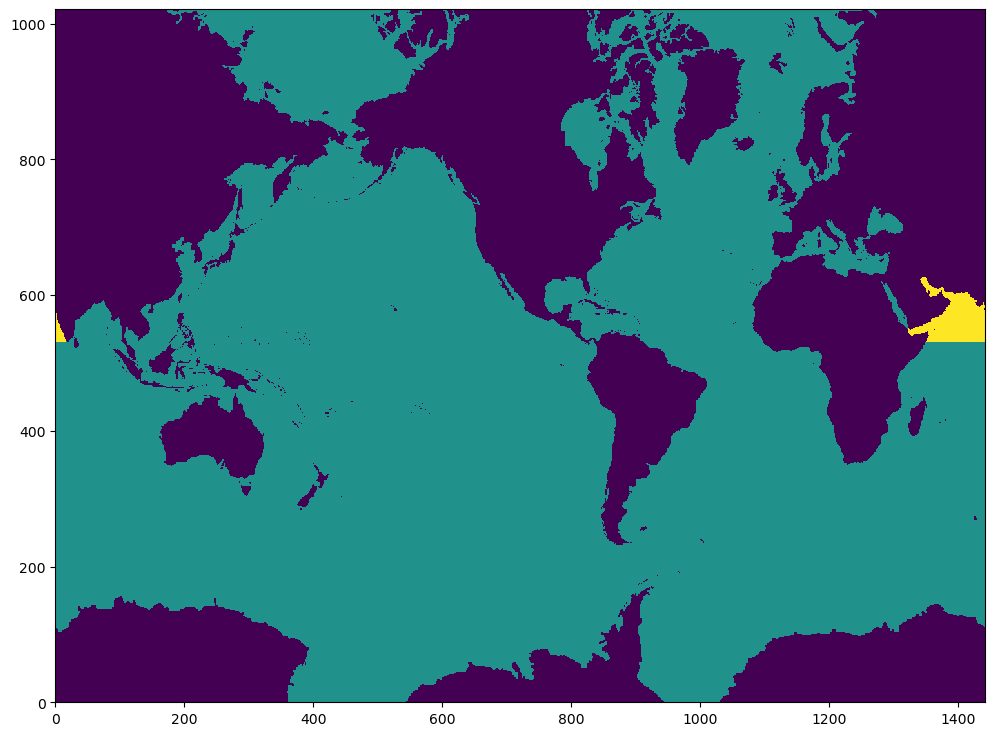

In [74]:
# Compute Arabian Sea if not Computed:
# Compute only if basins file already exists and connected not yet computed:
if os.path.isfile(basins):
    if not check_var(basins,'ArabianSea'):

        ncid  = Dataset(basins,'r')
        dims  = ncid.variables['Tmask'].get_dims()
        lon   = ncid.variables['lon'][:,:]
        lat   = ncid.variables['lat'][:,:]
        tmask            = ncid.variables['Tmask'][:,:]
        RedSea           = ncid.variables['RedSea'][:,:]
        BayOfBengal      = ncid.variables['BayOfBengal'][:,:]
        IndoPacific = ncid.variables['IndoPacific'][:,:]
        ncid.close()

        ArabianSea = copy.deepcopy(IndoPacific) - RedSea - BayOfBengal

        # Define Arabian Sea Region:
        ArabianSea[np.where(((lat < 8) | (lat > 31)) | ((lon <= 43.25) | (lon >= 77)))] = 0

        # Starting point in Arabian Sea:
        inds = np.unravel_index(np.argmin(np.abs(lat-15)+np.abs(lon-60)),np.shape(lon))
        sty = inds[0]
        stx = inds[1]

        find_points(ArabianSea,sty,stx)

        ncid = Dataset(basins,'a')
        ncid.createVariable('ArabianSea','f8',(dims[0].name,dims[1].name,))
        ncid.variables['ArabianSea'][:,:] = ArabianSea
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+ArabianSea,vmin=0,vmax=2)
        plt.plot(stx,sty,marker='o')
    else:
        ncid = Dataset(basins,'r')
        tmask     = ncid.variables['Tmask'][:,:]
        ArabianSea = ncid.variables['ArabianSea'][:,:]
        ncid.close()

        plt.figure(figsize=(12,9))
        plt.pcolormesh(tmask+ArabianSea,vmin=0,vmax=2)